<a href="https://colab.research.google.com/github/ethsd/build-a-wallet-2/blob/main/Build_a_Simple_Wallet_From_Scratch_Exploring_Foundations_of_Modern_Wallets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 2: Exploring  Foundations of Modern Wallets


## Outline
- Introduction
    - What is an HD wallet vs. Random Wallets
    - Use cases
- BIP 39
    - Generate Mnemonic words
    - Generate Seed from Mnemonic words
    
- Cryptographic Primitives (High Level)
    - HMAC-SHA512
    - PBKDF2
    - Elliptic Curve
    - RIPEMED160

- BIP 32
    - A closer look at HD wallets
    - Extended keys
    - fingerprints, chaincode, oh my!
    - Child Key derivation methods
    - Sample Tree creation
- BIP 44
    - Standard tree path/structure



Amazing (free online) Book
https://cypherpunks-core.github.io/ethereumbook/05wallets.html#bip44_path_examples

Great blog post (take home)
https://wolovim.medium.com/ethereum-201-hd-wallets-11d0c93c87f7

# Introduction

## Wallet Technology often is trying to strike balance between convenience and privacy
    - Max privacy: (new key for every  tx) but hard to manage
##  Wallets are keychains, but they don't hold tokens
##  Deterministic Wallet
    - all keys in the wallet are derived from a single (master) seed
## Random Wallets 
    - Each key in the wallet is derived from its own seed (no relation between keys)

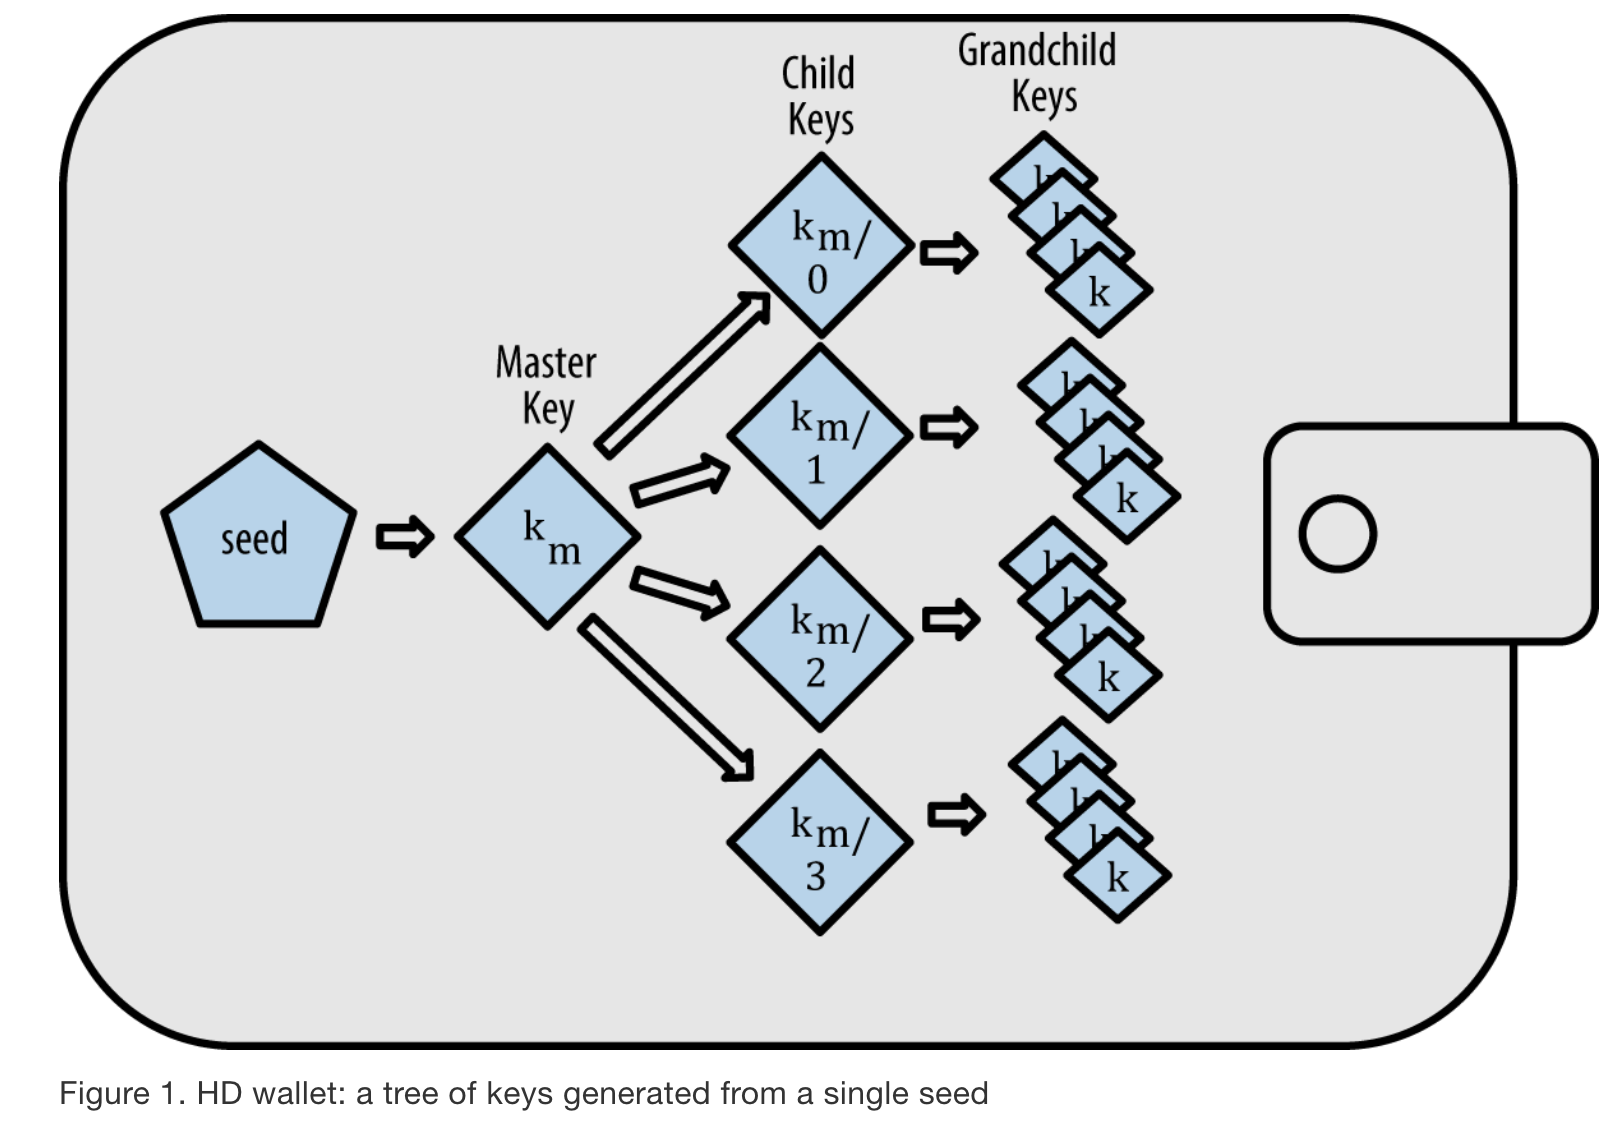

# Use Cases

https://en.bitcoin.it/wiki/BIP_0032

#### Full wallet sharing: m
- In cases where two systems need to access a single shared wallet, and both need to be able to perform spendings, one needs to share the master private extended key. Nodes can keep a pool of N look-ahead keys cached for external chains, to watch for incoming payments. The look-ahead for internal chains can be very small, as no gaps are to be expected here. An extra look-ahead could be active for the first unused account's chains - triggering the creation of a new account when used. Note that the name of the account will still need to be entered manually and cannot be synchronized via the block chain.

#### Audits: N(m/*)
- In case an auditor needs full access to the list of incoming and outgoing payments, one can share all account public extended keys. This will allow the auditor to see all transactions from and to the wallet, in all accounts, but not a single secret key.

#### Per-office balances: m/iH
- When a business has several independent offices, they can all use wallets derived from a single master. This will allow the headquarters to maintain a super-wallet that sees all incoming and outgoing transactions of all offices, and even permit moving money between the offices.

#### Recurrent business-to-business transactions: N(m/iH/0)
- In case two business partners often transfer money, one can use the extended public key for the external chain of a specific account (M/i h/0) as a sort of "super address", allowing frequent transactions that cannot (easily) be associated, but without needing to request a new address for each payment. Such a mechanism could also be used by mining pool operators as variable payout address.

#### Unsecure money receiver: N(m/iH/0)
- When an unsecure webserver is used to run an e-commerce site, it needs to know public addresses that are used to receive payments. The webserver only needs to know the public extended key of the external chain of a single account. This means someone illegally obtaining access to the webserver can at most see all incoming payments but will not be able to steal the money, will not (trivially) be able to distinguish outgoing transactions, nor be able to see payments received by other webservers if there are several.

# BIP 39: Mnemonic Word Generation

Blog on Mnemonic and seed generation
https://wolovim.medium.com/ethereum-201-mnemonics-bb01a9108c38

Official word list
https://github.com/bitcoin/bips/blob/master/bip-0039/bip-0039-wordlists.md

Trezor implementation of Mnemonic
https://github.com/trezor/python-mnemonic/blob/master/src/mnemonic/mnemonic.py


![MNEMONIC.png](attachment:MNEMONIC.png)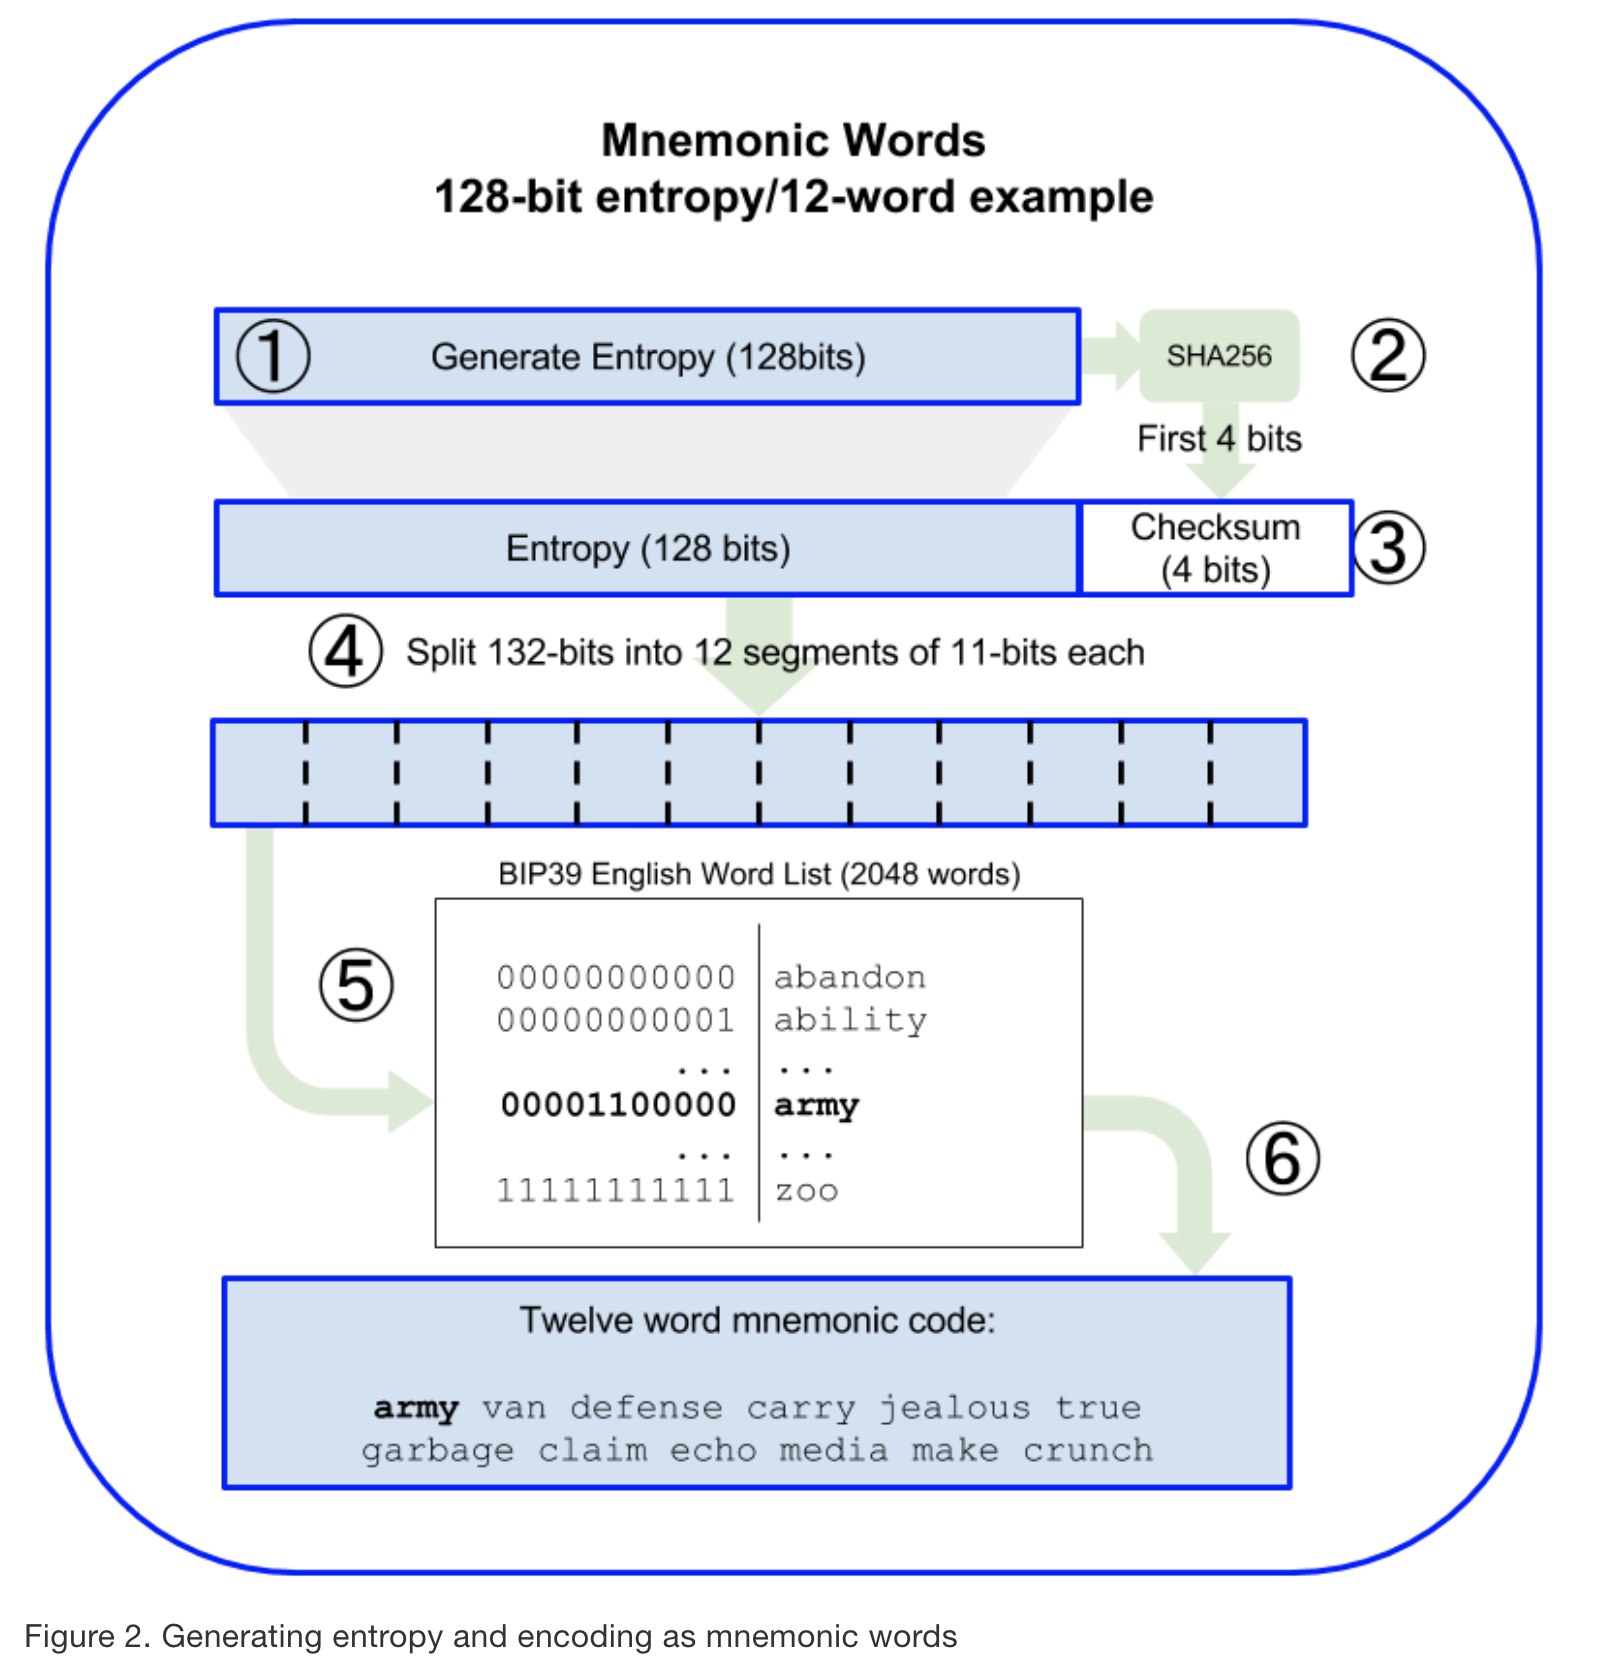

- Mnemonic phrases
    - easier to read and transcribe
- Seed creation
    - every passphrase leads to an (uninitialized) wallet

In [ ]:
import secrets
from hashlib import sha256

# STEP 1: Generate Random Bits (Entropy)

In [ ]:
entropy_bit_size =  128

# 8 bits = 1 byte
entropy_byte_size = 128 //8

#generate random bits
entropy = secrets.randbits(entropy_bit_size)

print(f"entropy: \n{entropy}\n")

#convert to binary
entropy_bits = "{0:b}".format(entropy)
print(f"entropy bits: \n{entropy_bits}\n")

entropy: 
65417967884331162110929019701382449398

entropy bits: 
110001001101110000101011010101110011101010011101010111101100011111101001001000001010101010100111100011011101011000100011110110



# STEP 2: Use Sha256 to obtain a hash of the Entropy

In [ ]:
# convert to bytes
entropy_bytes = entropy.to_bytes(entropy_byte_size,'big')

In [ ]:
hash_bytes = sha256(entropy_bytes).digest()
hash_bits = bin(int.from_bytes(b'y\xcc\xa6\xbb', byteorder='big'))[2:]

# STEP 3: Append the checksum to the end of the entropy


In [ ]:
checksum_length = entropy_bit_size // 32
print(checksum_length)

4


In [ ]:
checksum = hash_bits[:checksum_length]

In [ ]:
entropy_bits =  entropy_bits  + checksum

# STEP 4: Seperate entropy bits into 11 bit chunks


In [ ]:
bit_group  = [entropy_bits[i*11:(i+1)*11] for i in range(len(entropy_bits)//11)] 

In [ ]:
bit_group

['11000100110',
 '11100001010',
 '11010101110',
 '01110101001',
 '11010101111',
 '01100011111',
 '10100100100',
 '00010101010',
 '10100111100',
 '01101110101',
 '10001000111']

# STEP 5: Convert chunks into integers (indices)


In [ ]:
word_indices = [int(b,2) for b in bit_group]

In [ ]:
word_indices

[1574, 1802, 1710, 937, 1711, 799, 1316, 170, 1340, 885, 1095]

# STEP 6: Use indices to obtain words from the official word list!


In [ ]:
with open('english_bip39.txt', 'r') as file:
    english_word_list = file.read().strip().split()

In [ ]:
mnemonic_list = [english_word_list[index] for index in word_indices]

In [ ]:
mnemonic_list

['shadow',
 'throw',
 'still',
 'inside',
 'sting',
 'glue',
 'pig',
 'best',
 'pole',
 'huge',
 'material']

# Step 7: Convert list of words into one single string

In [ ]:
mnemonic_string = ' '.join(mnemonic_list)
print(mnemonic_string)

shadow throw still inside sting glue pig best pole huge material


# Generate Root Seed from Mnemonic (+ optional passphrase)

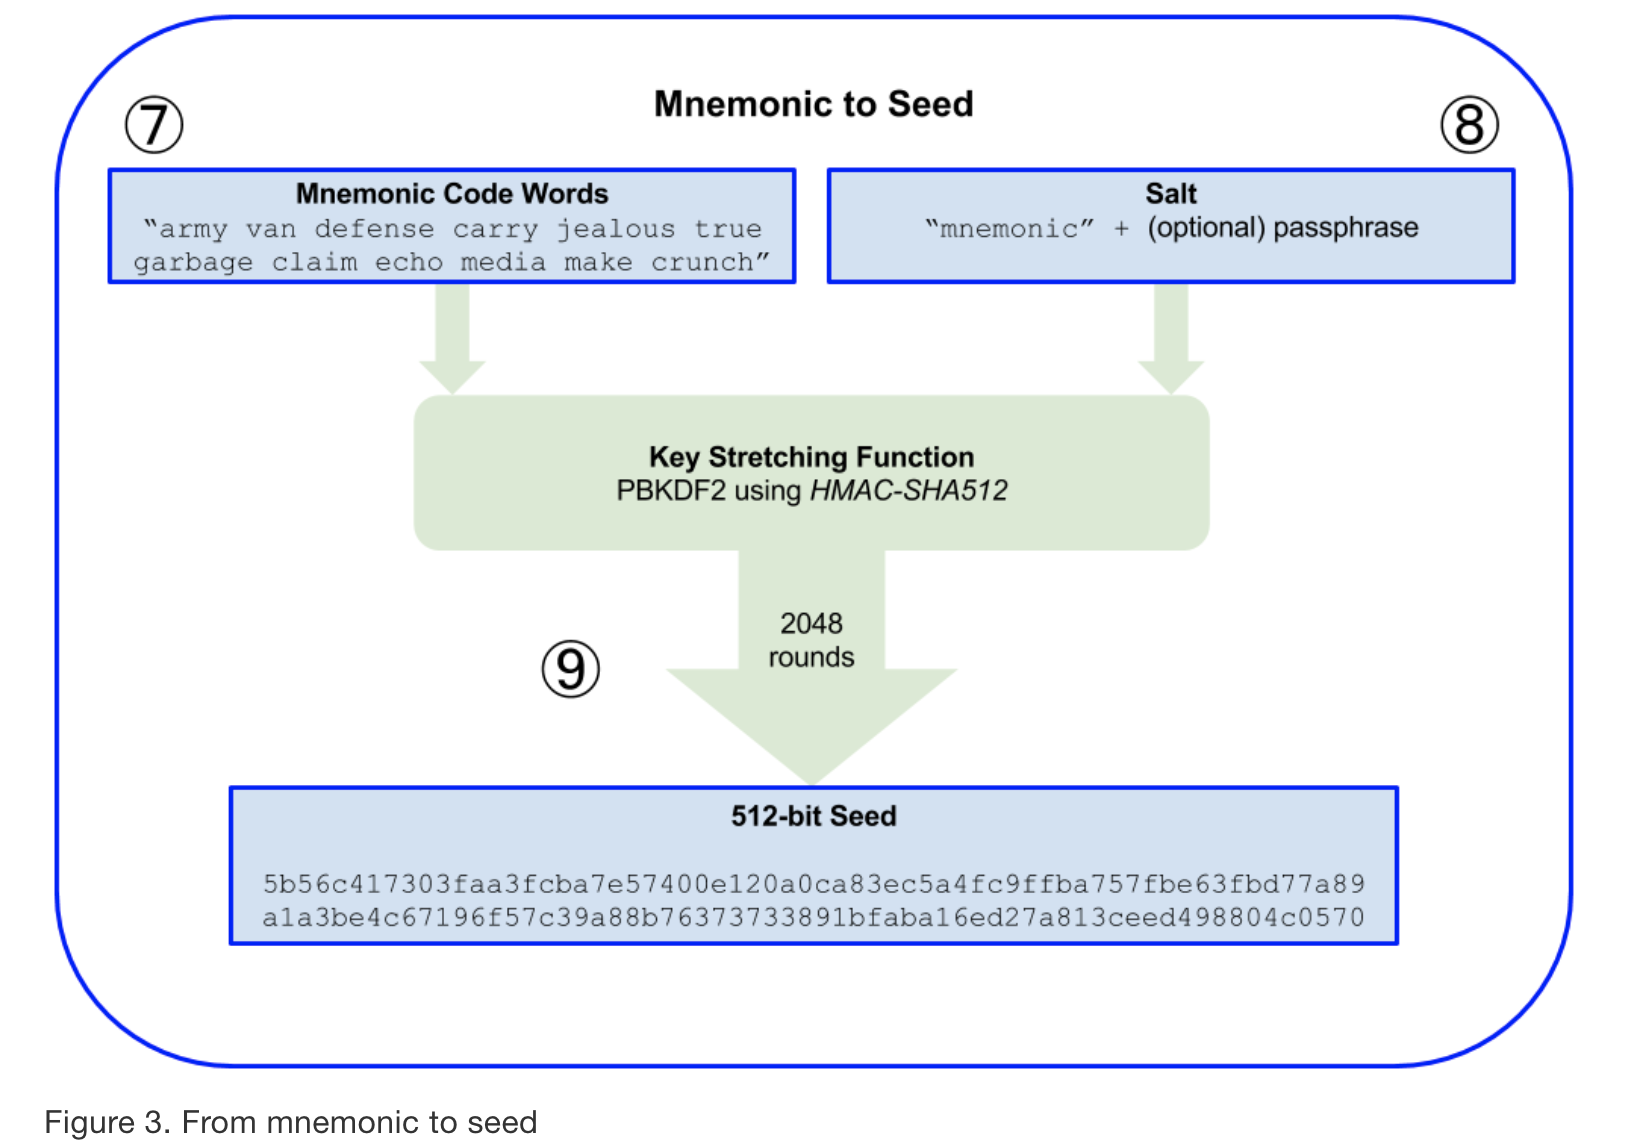

# HMAC-SHA512

- https://www.researchgate.net/figure/Elementary-SHA-512-operation-single-round_fig3_283184632
- http://uru.ac.in/uruonlinelibrary/Cyber_Security/Cryptography_and_Network_Security.pdf
- https://medium.com/@zaid960928/cryptography-explaining-sha-512-ad896365a0c1

-keyed hashing algorithm, provides data integrity and authenticity to the data...


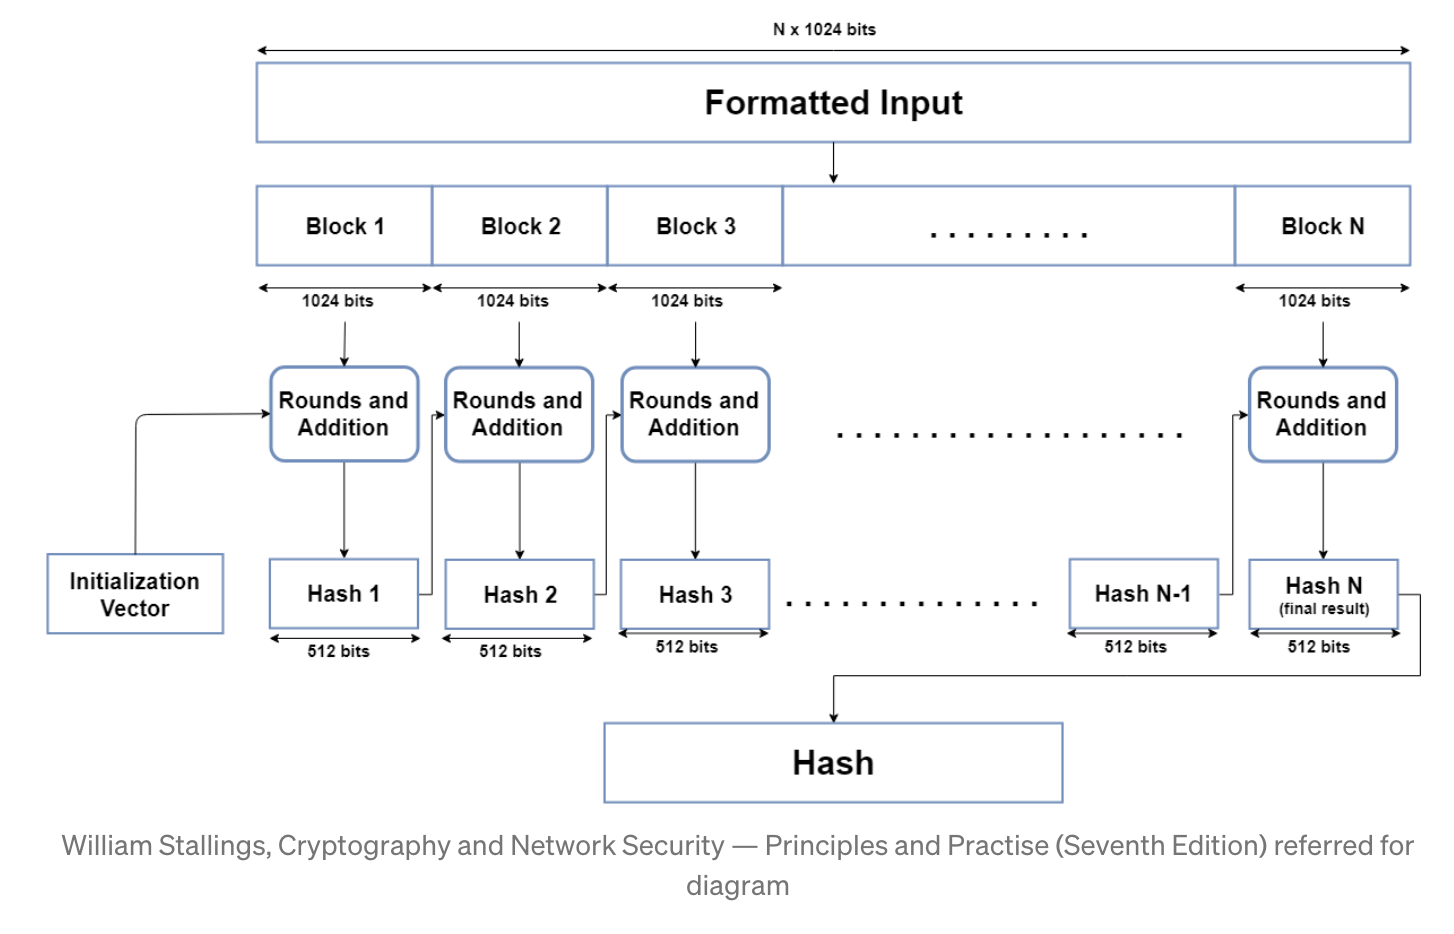

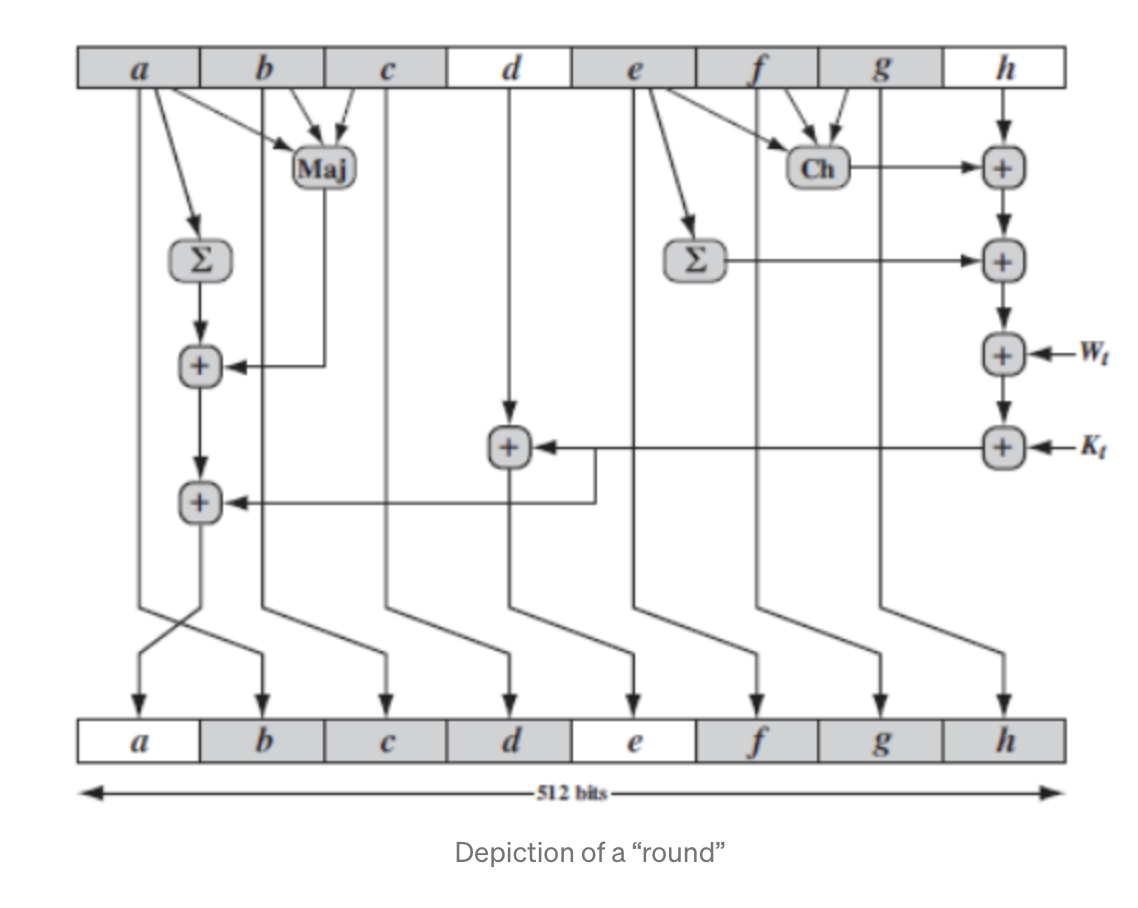

# PBKDF2 (Password-based Key Derivation Functions)

https://en.wikipedia.org/wiki/PBKDF2

DK = PBKDF2(PRF, Password, Salt, c, dkLen)

- PRF = HMAC-SHA512
- Password = mnemonic
- Salt = optional passphrase
- c = number of rounds
- dkLen = length of derived key 
- DK = derived key

The key-stretching function, with its 2,048 rounds of hashing, is a somewhat effective protection against brute-force attacks against the mnemonic or the passphrase. It makes it costly (in computation) to try more than a few thousand passphrase and mnemonic combinations, while the number of possible derived seeds is vast (2512, or about 10154)—far bigger than the number of atoms in the visible universe (about 1080).

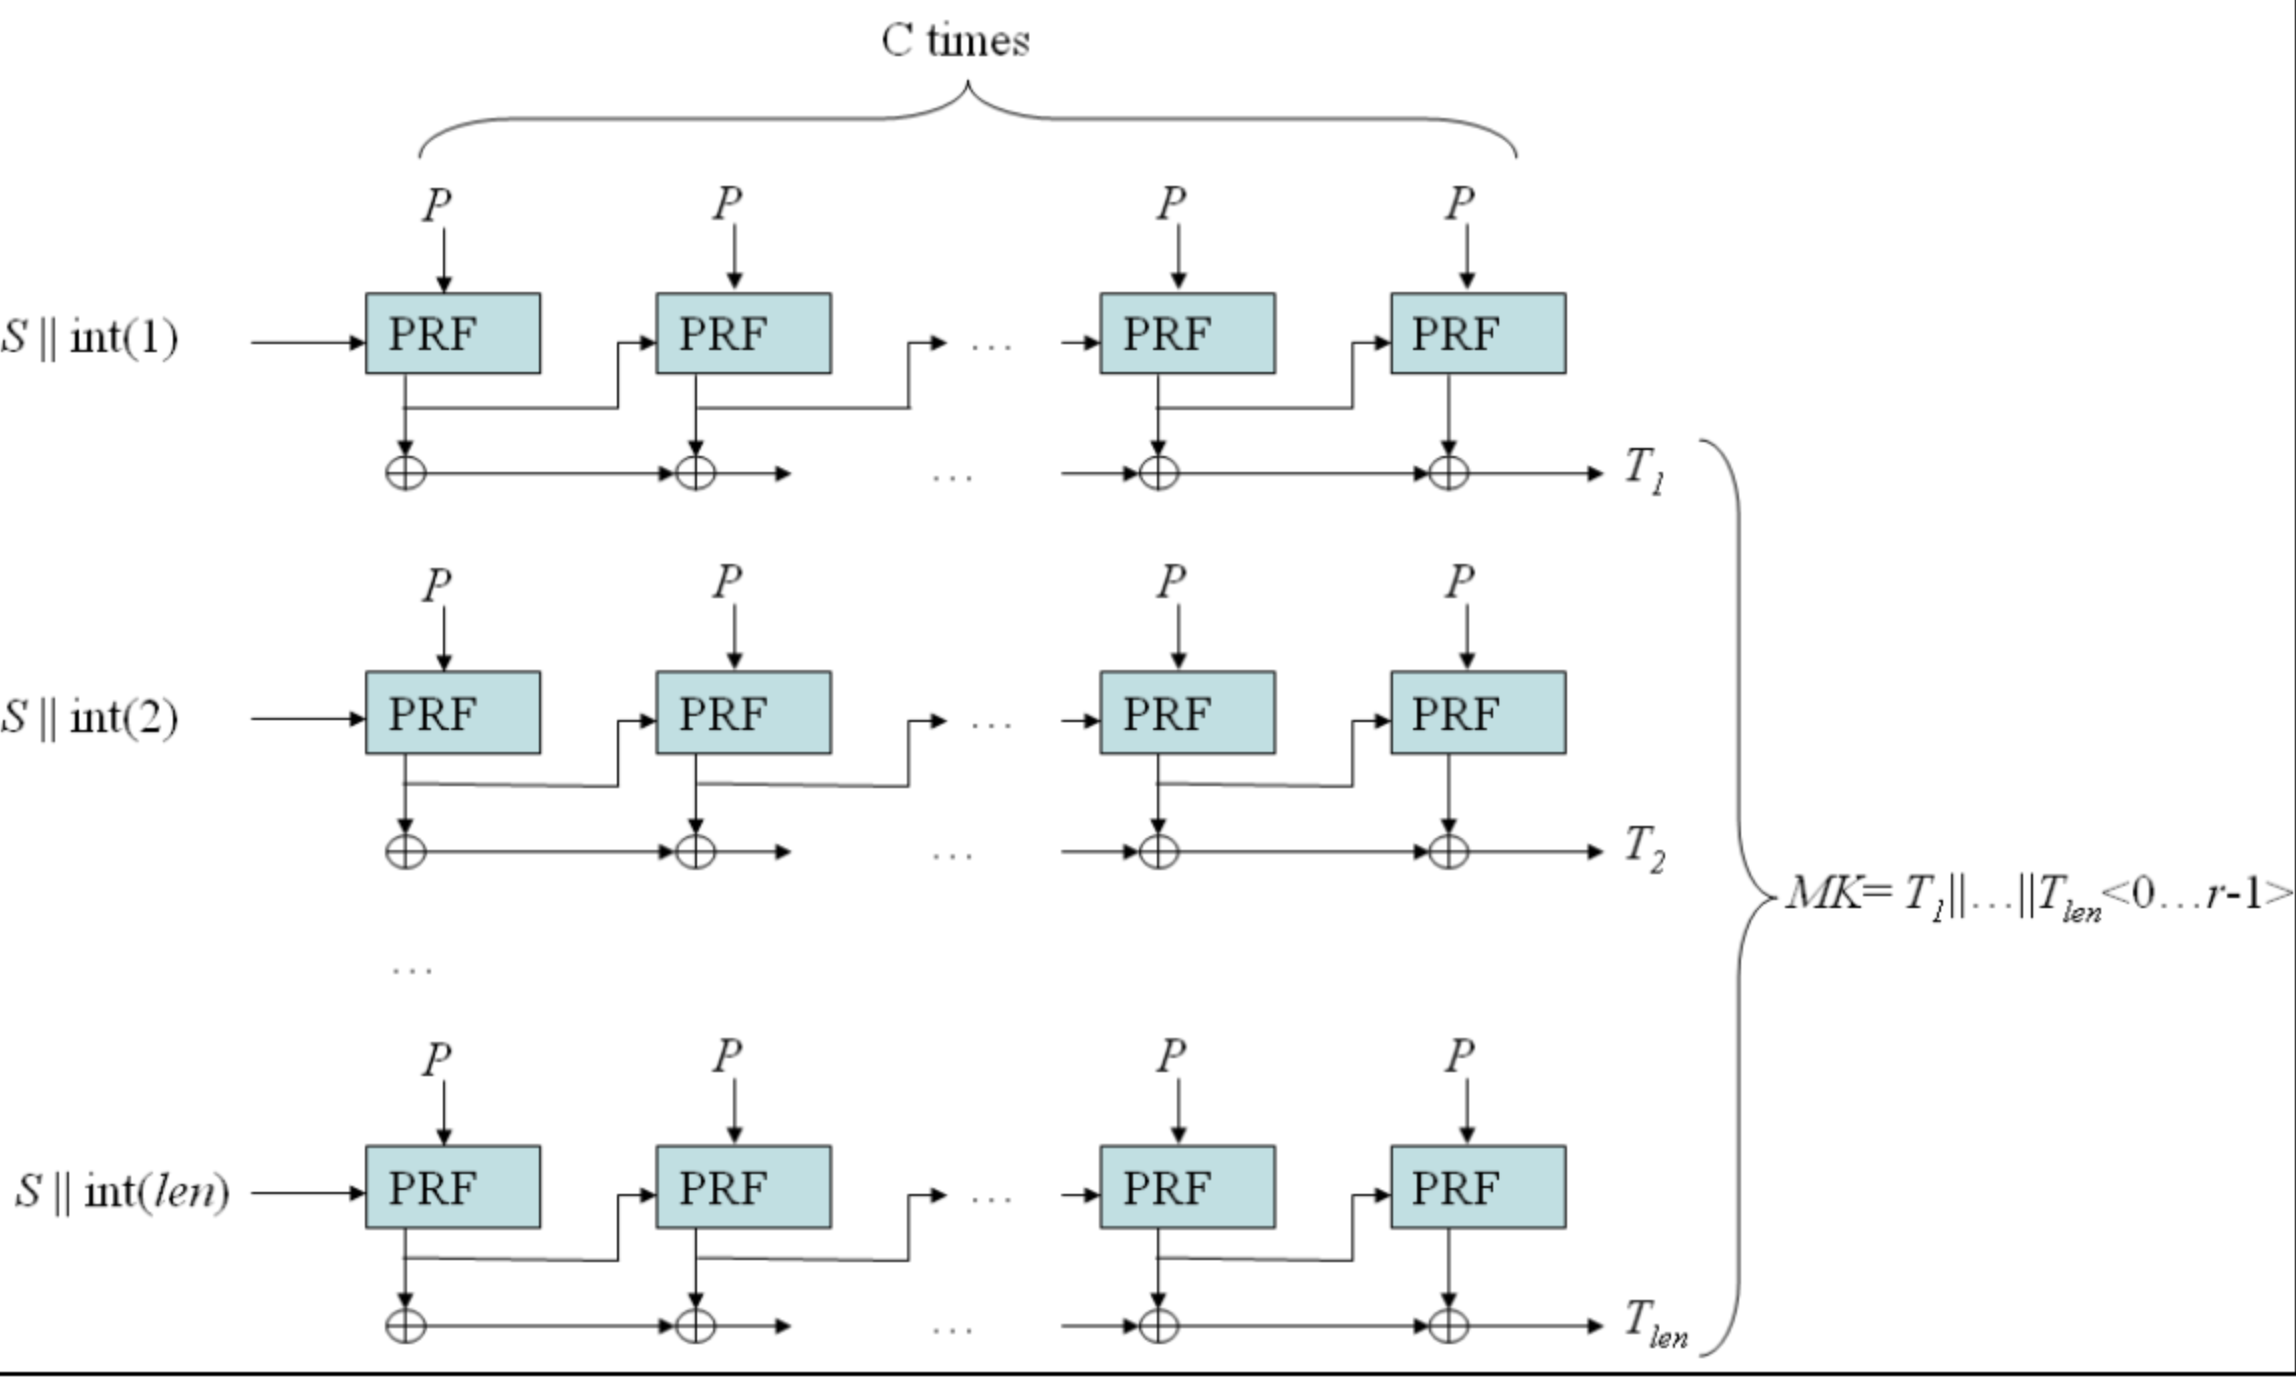

In [ ]:
from hashlib import pbkdf2_hmac

# Step 8: Define your salt

In [ ]:
salt = "mnemonic" # + passphrase (optional)

# Step 9: Use PBKDF2

In [ ]:
seed = pbkdf2_hmac(
   "sha512", 
   mnemonic_string.encode("utf-8"), 
   salt.encode("utf-8"), 
   2048
)

seed = seed.hex()

NameError: ignored

In [ ]:
seed

NameError: ignored

## BIP 32: HD (Hierarchical Deterministic Wallets)

Interactive Demo Site
http://bip32.org/

Cheat Sheet
https://tzumby.github.io/bip32_cheat_sheet/

Core Codebase
https://github.com/bitcoin/bips/blob/master/bip-0032.mediawiki#Private_parent_key_rarr_private_child_key

Nice tutorial
https://github.com/marcgarreau/ethereum-notebooks/blob/master/bip32.ipynb

https://en.bitcoin.it/wiki/BIP_0032

- HD Wallets
    - extended keys are prefixed w/ xprv or xpub
    - all child keys can be derived from their parent extended key
    - chain codes are used to link them
    - Two ways to create public keys
        - from the parent public
        - from the child private key

One weakness that may not be immediately obvious, is that knowledge of a parent extended public key plus any non-hardened private key descending from it is equivalent to knowing the parent extended private key (and thus every private and public key descending from it).

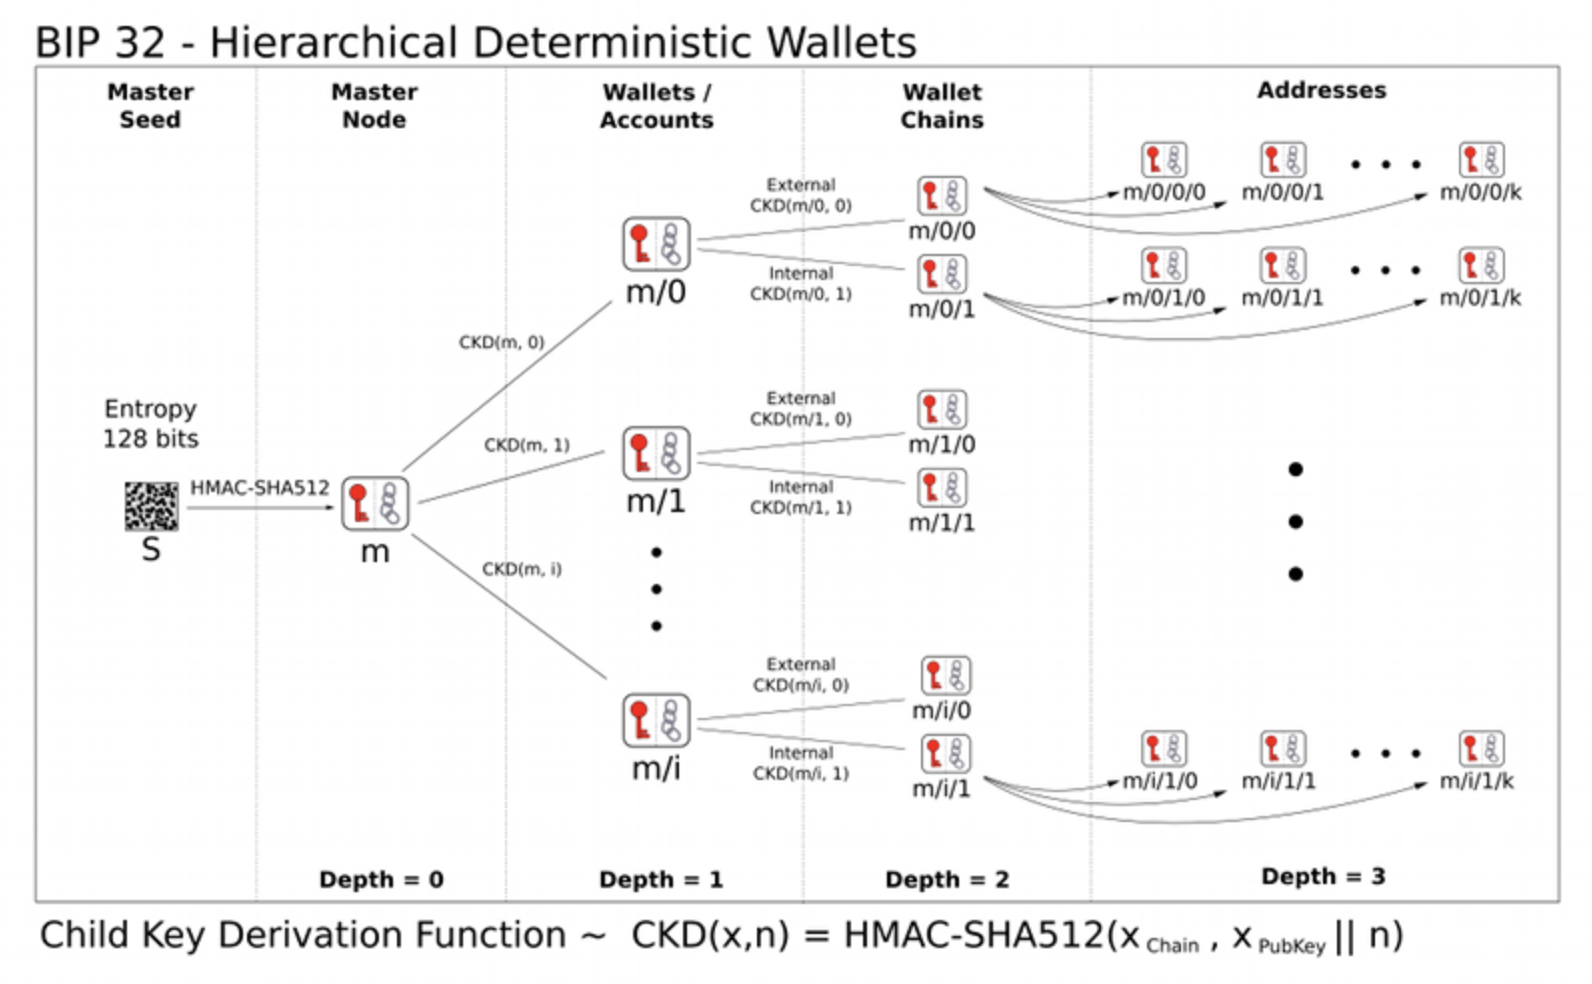

In [ ]:
import binascii
import hmac
import hashlib

# Derive Master Key from Seed

In [ ]:
# the HMAC-SHA512 `key` and `data` must be bytes:
seed_bytes = binascii.unhexlify(seed)
print(f'seed_bytes: \n{seed_bytes}\n')


NameError: ignored

# Using keyed hashing for deriving child keys

- HMAC-SHA512 takes as input a secret key and a message
- As per BIP32, the output (digest) is split in half
    - First half is used for the Key
    - Second half is used for the chaincode

In [ ]:
I = hmac.new(b'Bitcoin seed', seed_bytes, hashlib.sha512).digest()
L, R = I[:32], I[32:]
print(f'L: \n{L}\n')
print(f'R: \n{R}\n')

NameError: ignored

In [ ]:
master_private_key = int.from_bytes(L, 'big')
master_chain_code = R

print(f'master private key (hex): \n{hex(master_private_key)}\n')
print(f'master chain code (bytes): \n{master_chain_code}\n')

master private key (hex): 
0x92c97a3da4198a4e45649ae9101555507618f0b0eefb595290814fb6f936bed3

master chain code (bytes): 
b'\xa1\x15j\x9d\xd2\xca\xcc\xe41\xbb\x95V6z\xefv`B\x9b\xf6\xa32{\xb8}\xe9W5\xa3W0\xda'



# Chaincode

- In BIP32, the chaincode serves as an extra source of entropy that is identical for corresponding public and private keys

# Serialize the extended (master) private key

- 78 bytes in total
- calculating public keys from private keys is represented in curve_point_from_int()
    - security feature of ECDSA, that you can't find private from  public key
- serialization is a formatting step specific to BIP32
- fingerprints are just a convenient way to lookup the parent key of a given key, (only 4 bytes)
    - there's a risk of collisions, but this is just something for software to consider

In [ ]:
!pip install base58

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import base58

VERSION_BYTES = {
    'mainnet_public': binascii.unhexlify('0488b21e'),
    'mainnet_private': binascii.unhexlify('0488ade4'),
    'testnet_public': binascii.unhexlify('043587cf'),
    'testnet_private': binascii.unhexlify('04358394'),
}

version_bytes = VERSION_BYTES['mainnet_private']
depth_byte = b'\x00'
parent_fingerprint = b'\x00' * 4
child_number_bytes = b'\x00' * 4
key_bytes = b'\x00' + L

all_parts = (
    version_bytes,      # 4 bytes  
    depth_byte,         # 1 byte
    parent_fingerprint, # 4 bytes
    child_number_bytes, # 4 bytes
    master_chain_code,  # 32 bytes
    key_bytes,          # 33 bytes
)

all_bytes = b''.join(all_parts)
root_key = base58.b58encode_check(all_bytes).decode('utf8')
print(f'root key: \n{root_key}\n')

root key: 
xprv9s21ZrQH143K3fNhTrybcr9B4qQNX2x8WFddUgzyxAwmHE5oveankssa58UkUPUGXM5BNq2AYR6TPtg9otPgtpJziaPtwdfsE69H7stdRCe



# Elliptic Curve  Cryptography

https://onyb.gitbook.io/secp256k1-python/ecdsa


https://andrea.corbellini.name/2015/05/17/elliptic-curve-cryptography-a-gentle-introduction/


In [ ]:
!pip install  ecdsa==0.14

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 83 kB 1.7 MB/s 


In [ ]:
from ecdsa import SECP256k1
from ecdsa.ecdsa import Public_key

In [ ]:
SECP256k1_GEN = SECP256k1.generator
SECP256k1_ORD = SECP256k1.order

In [ ]:
#Derive a public key from a private key
def curve_point_from_int(k):
   return Public_key(SECP256k1_GEN, SECP256k1_GEN * k).point

In [ ]:
# Formatting as specified in the BIP32 standard (originally from SEC1)
def serialize_curve_point(p):
   x = p.x()
   y = p.y()
   if y & 1:
      return b'\x03' + x.to_bytes(32, 'big')
   else:
      return b'\x02' + x.to_bytes(32, 'big')

#  Review:  Can always derive a public key from a private key using ECDSA

In [ ]:
# Derive the public key Point:
p = curve_point_from_int(master_private_key)
print(f'Point object: {p}\n')

# Serialize the Point, p
public_key_bytes = serialize_curve_point(p)

print(f'public key (hex): 0x{public_key_bytes.hex()}')

Point object: (78952104180670166818944262588245393835692353189774219794504526436534368096234,39302088259087083951676194880641524980195345937870575848035427169648466493874)

public key (hex): 0x02ae8d4eb05dd6c89952bc4d0a96c4221627ca60b395555fb844cb658c97ec4fea


# Derive the parent fingerprint

- fingerprints are needed to derive keys, they are a convenient, short identifier for finding parent keys.intended to be used by software programs

In [ ]:
def fingerprint_from_priv_key(k):
    
    # notice this is just deriving public key from private key
    K = curve_point_from_int(k)
    K_compressed = serialize_curve_point(K)
    
    # use ripemd160
    identifier = hashlib.new(
      'ripemd160',
      hashlib.sha256(K_compressed).digest(),
    ).digest()
    
    # return the first 4 bytes
    return identifier[:4]

## Ripemd160

https://www.slideshare.net/chuxuantinh/md5-hash-functions-ripemd160

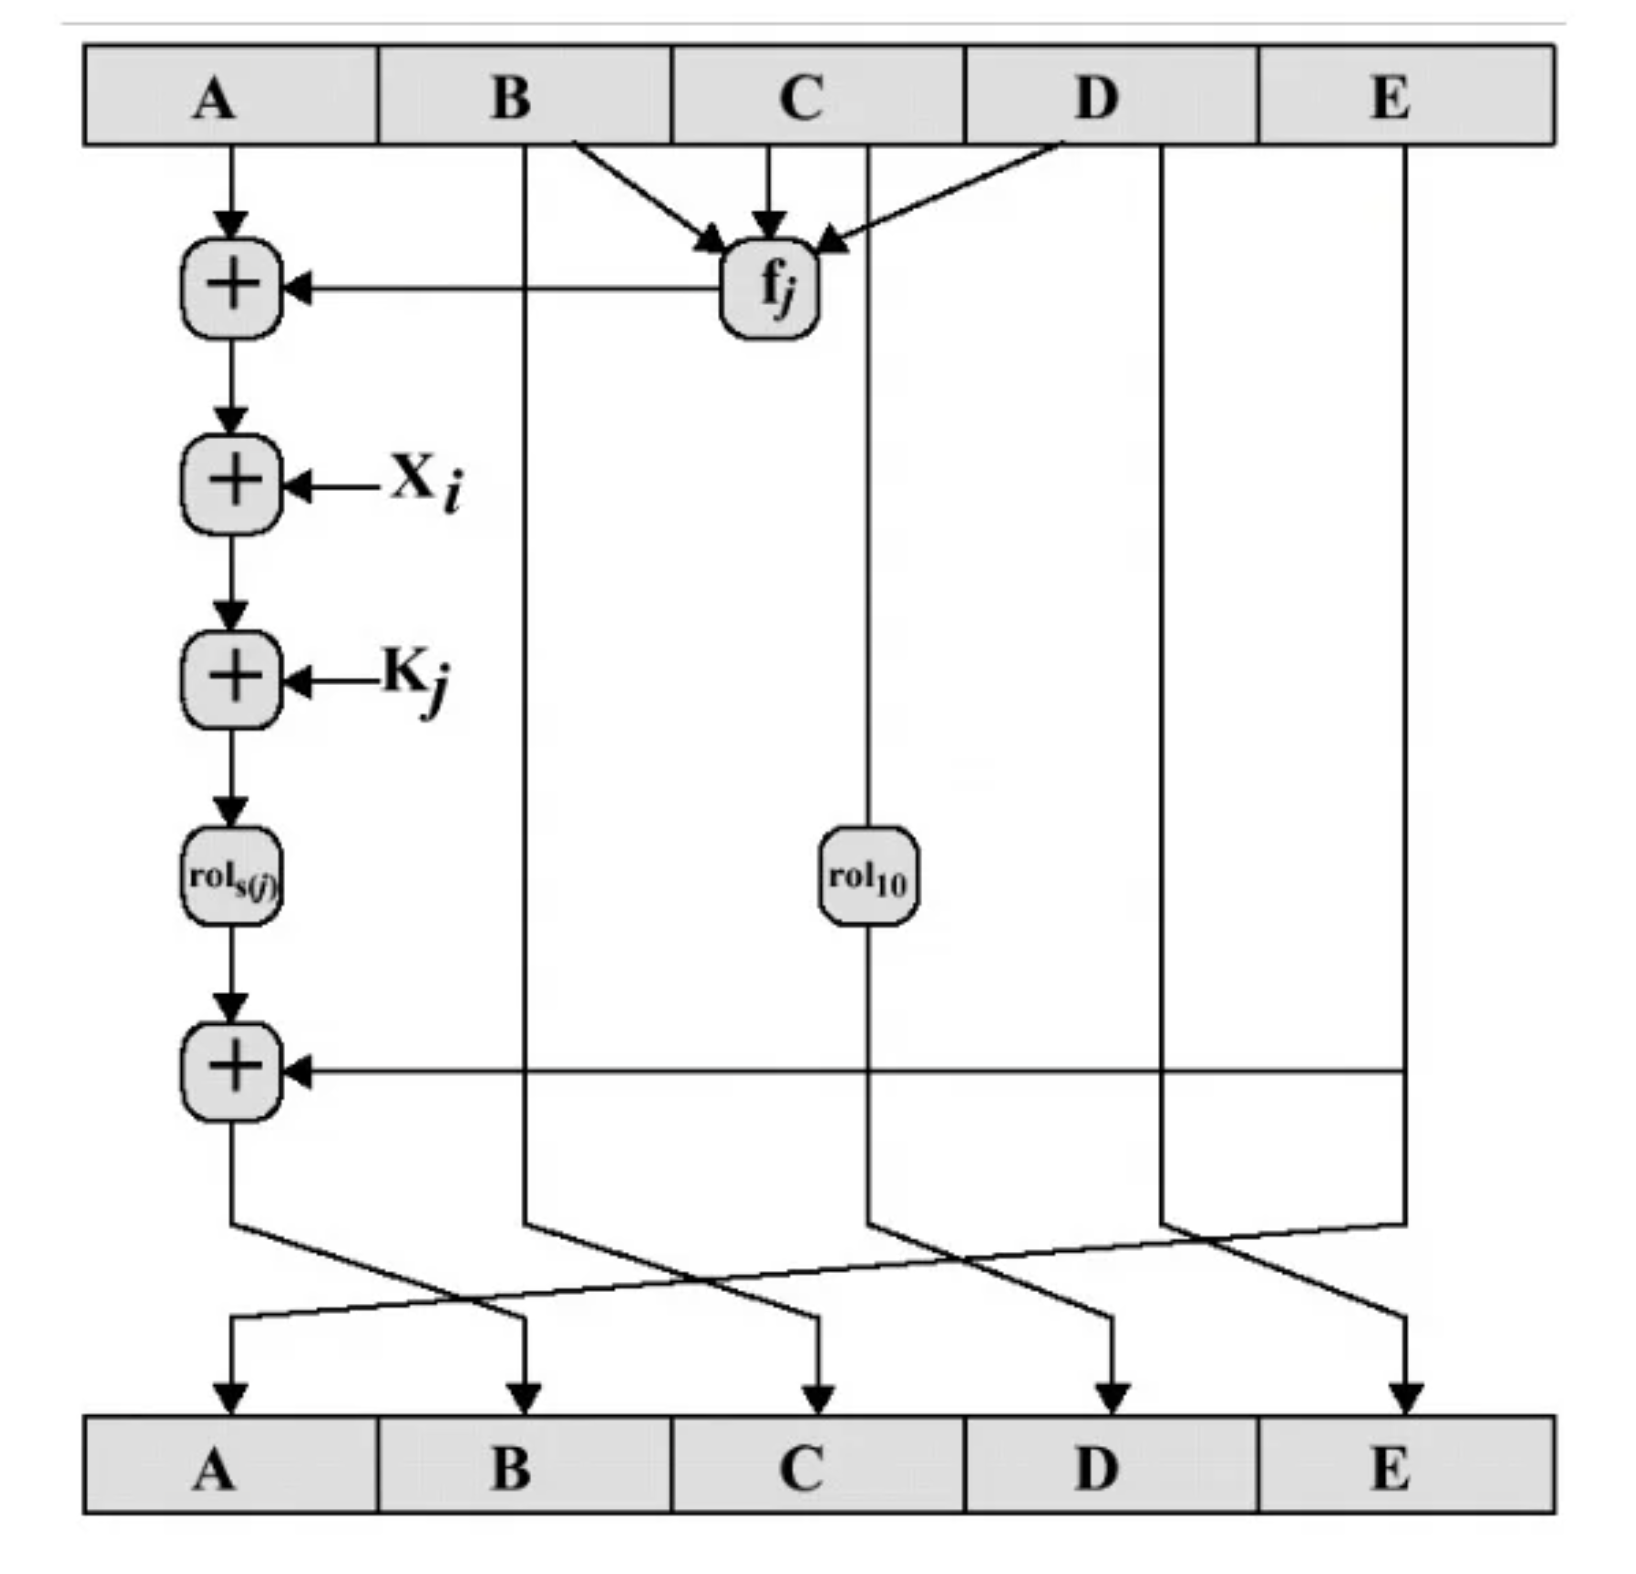

#  Child Key Derivation

https://medium.com/@robbiehanson15/the-math-behind-bip-32-child-key-derivation-7d85f61a6681



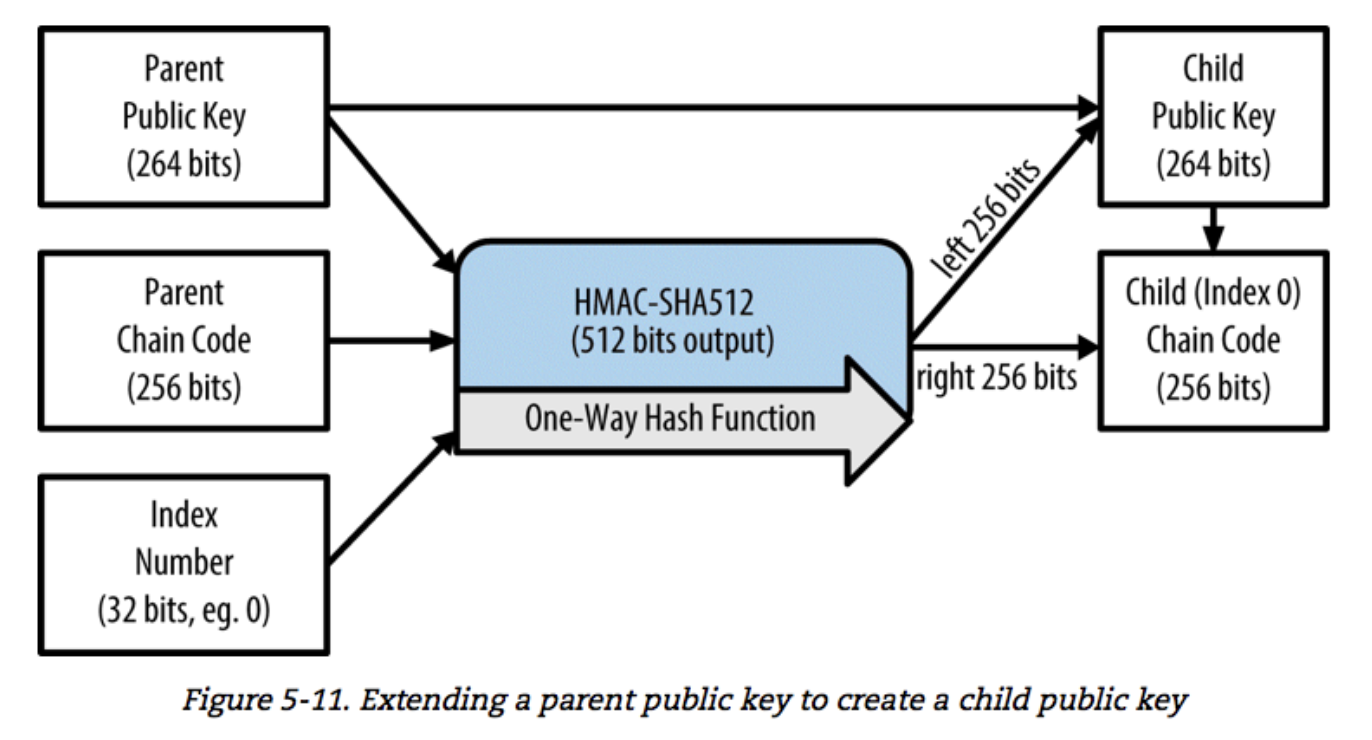

In [ ]:
def pub_parent_2_pub_child(public_key, chain_code, child_number):

    data = serialize_curve_point(public_key)

    data += child_number.to_bytes(4, 'big')

    hmac_bytes = hmac.new(chain_code, data, hashlib.sha512).digest()
    L, R = hmac_bytes[:32], hmac_bytes[32:]

    L_as_int = int.from_bytes(L, 'big')
    

    child_public_key = (curve_point_from_int(L_as_int) + public_key)
    child_chain_code = R

    return (child_public_key, child_chain_code)

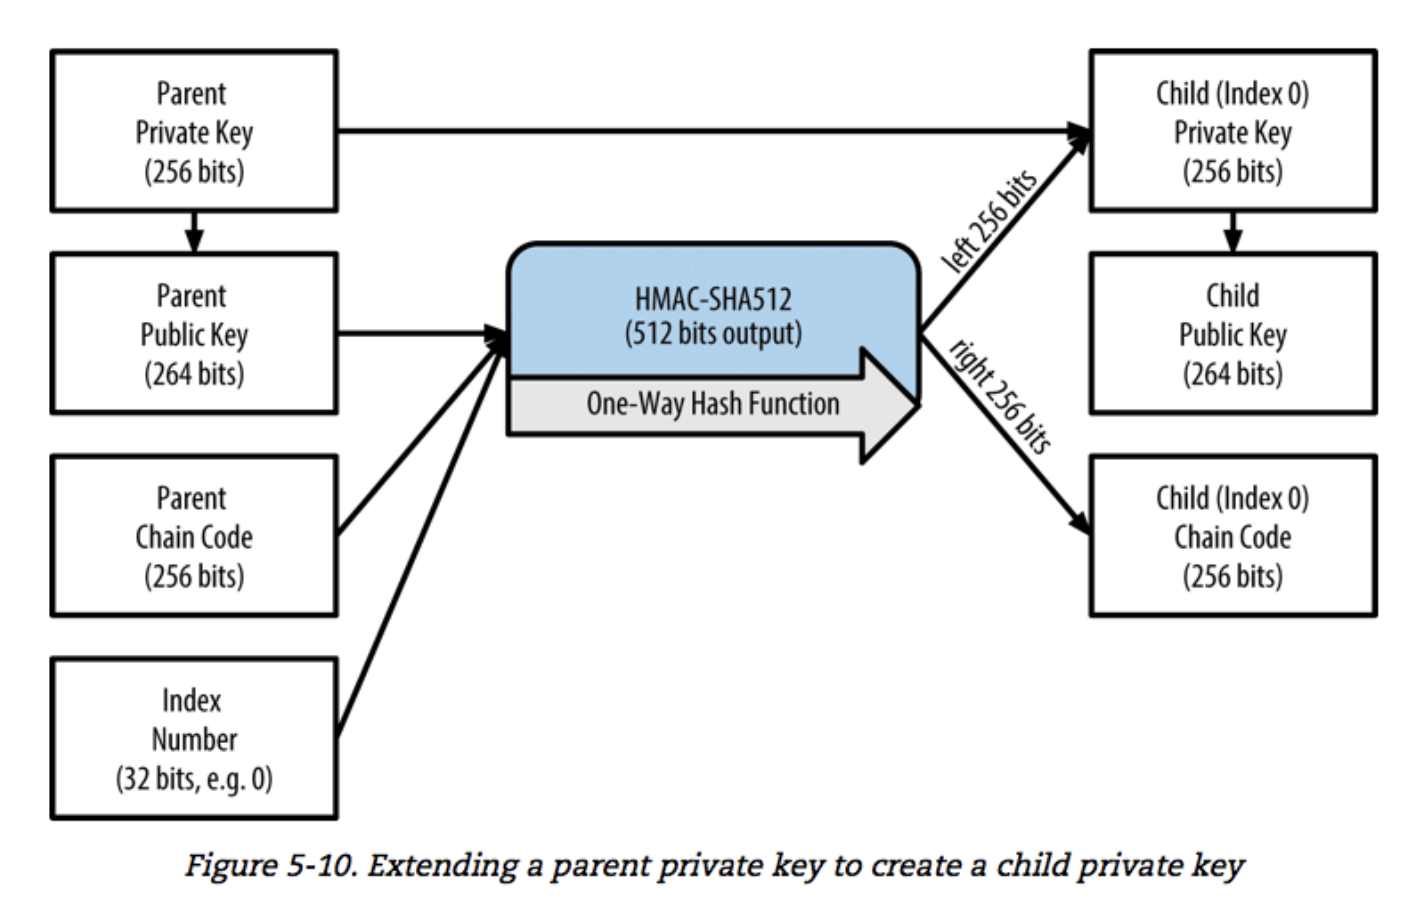

In [ ]:
def priv_parent_2_priv_child(private_key, chain_code, child_number):
    if child_number >= 2 ** 31:
        # Generate a hardened key
        data = b'\x00' + private_key.to_bytes(32, 'big')
    else:
        # Generate a non-hardened key
        p = curve_point_from_int(private_key)
        data = serialize_curve_point(p)

    data += child_number.to_bytes(4, 'big')

    hmac_bytes = hmac.new(chain_code, data, hashlib.sha512).digest()
    L, R = hmac_bytes[:32], hmac_bytes[32:]

    L_as_int = int.from_bytes(L, 'big')

    #
    child_private_key = (L_as_int + private_key) % SECP256k1_ORD
    child_chain_code = R

    return (child_private_key, child_chain_code)

In [ ]:
parent_private_key = 26331713851941227727420573950421422814779379982343269243753615692356231759895
parent_chaincode = b"n\rQ\xd0\xec)\xf5\xdd\x88'_\x1f\xa2!\xfd\x834\x1a\x1c\xf4\xd0\xcc\xe4,{\xcd\xf3\xcd8\xd9bg"
private_key, chain_code_A = priv_parent_2_priv_child(parent_private_key, parent_chaincode, 1)

print(f"private_key: \n{private_key}\n")
print(f"chain_code: \n{chain_code_A}\n")

private_key: 
55990660657416872235500864686515462437732170123669564016300062523079375789090

chain_code: 
b'\xc6\x92\xae\xd5\xa1ea\xee\x8e\xee\x1ad\xd0`\xd40\xec\x9a\xd9`jOS\x15\xb7\xac\xe2\xc2\xf9\xac\xe5n'



In [ ]:
# deriving public key from private using ECDSA
parent_public_key = curve_point_from_int(parent_private_key)

In [ ]:
public_key, chain_code_B = pub_parent_2_pub_child(parent_public_key, parent_chaincode, 1)

print(f"private_key: \n{public_key}\n")
print(f"chain_code: \n{chain_code_B}\n")

private_key: 
(19036195198296493414616329346108097366028065326355937930351548653947306942829,83278171562134025407592693988732865200801244029273493467172488671433373034097)

chain_code: 
b'\xc6\x92\xae\xd5\xa1ea\xee\x8e\xee\x1ad\xd0`\xd40\xec\x9a\xd9`jOS\x15\xb7\xac\xe2\xc2\xf9\xac\xe5n'



## Non-Hardened takeways


###  Notice chain codes are identical even though one came from parent private key and the other the parent  public key

In [ ]:
chain_code_A == chain_code_B

True


### The child public key can also be derived from the child private key as usual, and will be the same as the child public key derived from the parent public key 

In [ ]:
serialize_curve_point(public_key) == serialize_curve_point(curve_point_from_int(private_key))

True

# Hardened Keys

### Key points:
-  "A single leaked child private key, together with a parent chain code, reveals all the private keys of all the children. Worse, the child private key together with a parent chain code can be used to deduce the parent private key."

- "Each extended key has 231 normal child keys, and 231 hardened child keys. Each of these child keys has an index. The normal child keys use indices 0 through 231-1. The hardened child keys use indices 231 through 232-1. To ease notation for hardened key indices, a number iH represents i+231."

    - If hardened child key is desired, add 2^31 to the child index 

In [ ]:
parent_private_key = 26331713851941227727420573950421422814779379982343269243753615692356231759895
parent_chaincode = b"n\rQ\xd0\xec)\xf5\xdd\x88'_\x1f\xa2!\xfd\x834\x1a\x1c\xf4\xd0\xcc\xe4,{\xcd\xf3\xcd8\xd9bg"
private_key_hardened, chain_code_hardened = priv_parent_2_priv_child(parent_private_key, parent_chaincode, 1+2**31)

print(f"private_key: \n{private_key_hardened}\n")
print(f"chain_code: \n{chain_code_hardened}\n")

private_key: 
110073511648134367690949130491337557306020558426857681924414417718094588801068

chain_code: 
b'\x91\x8e\xdb\xd5\x8a\x86\x9c\x1aLK\xdc\xdb\x0c-I\x8e\xc2\x02w[{\xf0H*D\xa4\xa8\x9d\xc6b\x83\xe5'



In [ ]:
public_key_non_hardened, chain_code_non_hardened = pub_parent_2_pub_child(parent_public_key, parent_chaincode, 1+2**31)

print(f"private_key: \n{public_key_non_hardened}\n")
print(f"chain_code: \n{chain_code_non_hardened}\n")

private_key: 
(4599155542011779275256539489046274130691001067940345924418712857803581850386,10445285200582595223924025667552581869192114557348214051997762107070517516128)

chain_code: 
b'eW\xf2Fvs(n\xbc#\xc2m\xaa\xfd\x19G\x10\x1f\xe4\xe1]\x9e\xf3cT\xb38$\xa1\x07\xd3\xec'



## Chain codes are different. This is good for security and prevents attacker from learning the parent Private key!

In [ ]:
chain_code_non_hardened == chain_code_hardened

False

## As  usual, the corresponding public key to hardened private key can  be derived using ECDSA, but it will be different from the public  key that was derived (despite being from the same parent!)

### ....This is because hardened keys hash the parent private key instead of the parent public key!

In [ ]:
serialize_curve_point(public_key_non_hardened)==serialize_curve_point(curve_point_from_int(private_key_hardened))

False

# Sample HD Generation

In [ ]:
# Break each depth into integers (m/44'/60'/0'/0/0)
#    e.g. (44, 60, 0, 0, 0)
# If hardened, add 2*31 to the number:
#    e.g. (2**31 + 44, 2**31 + 60, 2**31 + 0, 0, 0)
path_numbers = (1, 2, 3, 0, 0)

depth = 0
parent_fingerprint = None
child_number = None
private_key = master_private_key
chain_code = master_chain_code

for i in path_numbers:
    depth += 1
    print(f"depth: {depth}")
    
    child_number = i
    print(f"child_number: {child_number}")
    
    parent_fingerprint = fingerprint_from_priv_key(private_key)
    print(f"parent_fingerprint: {parent_fingerprint}")
    
    private_key, chain_code = priv_parent_2_priv_child(private_key, chain_code, i)
    print(f"private_key: {private_key}")
    print(f"chain_code: {chain_code}\n")

depth: 1
child_number: 1
parent_fingerprint: b'4\x11^\x93'
private_key: 73015303613821160423092833563669195651117574126805507829333591335425637741385
chain_code: b'T\x16c\xb2\xf7\xbadt\xf2\x17\x02\xcbTvH{\x03\xa9F\xe9\xd3,]\xe2Q4\x80~_\xcd\xde\xa4'

depth: 2
child_number: 2
parent_fingerprint: b'\xecY\x80a'
private_key: 67751434501045838975119441941496379439318850292570766610163634372816518287581
chain_code: b'\xce\x1d\r\xc0QX\x11\xdc\x8cgXI\xb7F\x98\x8d<\x87\xc6@\x85\x06?\x9f\x81\xf9\xfa\x9c\xbd\xfc\xefv'

depth: 3
child_number: 3
parent_fingerprint: b'\xa5\x00\xc81'
private_key: 115141228964682678907126649570712712053794484564742898759653711126766023716657
chain_code: b'\x83%;I]\xe5c"\xa5wH\x8cQ\xdb\xa8\xd3\xd4\t\x1a\xe0\xcf]\x0c\xfa<\xad\xb1R\xb6\x1d\xf6"'

depth: 4
child_number: 0
parent_fingerprint: b'\x9b\xc3\xc7\\'
private_key: 55254119474347224898834774877033095220600771093595087413052505853939035418850
chain_code: b'\xad\xf8\x16\x8dEM\x19\xf1\xa1\xda\xd8R\xae $\xcb\x16\xc7\x94

## Review: Derive Ethereum Address from public key

In [ ]:
!pip install pycryptodome


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 11.7 MB/s 


In [ ]:
from Crypto.Hash import keccak
keccak_hash = keccak.new(digest_bits=256)
eth_address = keccak_hash.update(public_key_bytes).digest()[-20:]
keccak_digest = keccak_hash.digest()

In [ ]:
# NOTE: type changing from bytes to int, and back to hex string again :)
eth_address_int = int.from_bytes(eth_address, "big")
eth_address = hex(eth_address_int)

In [ ]:
eth_address

'0x348608705bfeeeba6eba17dea66ced488b03890c'

# BIP  44: Multipurpose HD Wallet

https://github.com/bitcoin/bips/blob/master/bip-0044.mediawiki

https://github.com/satoshilabs/slips/blob/master/slip-0044.md

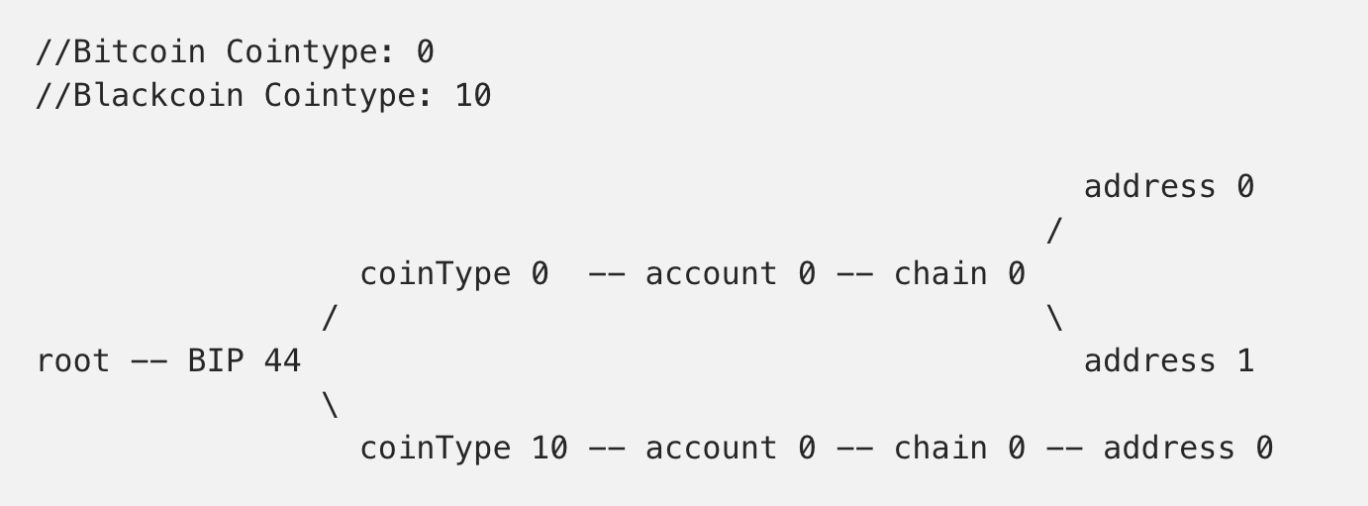

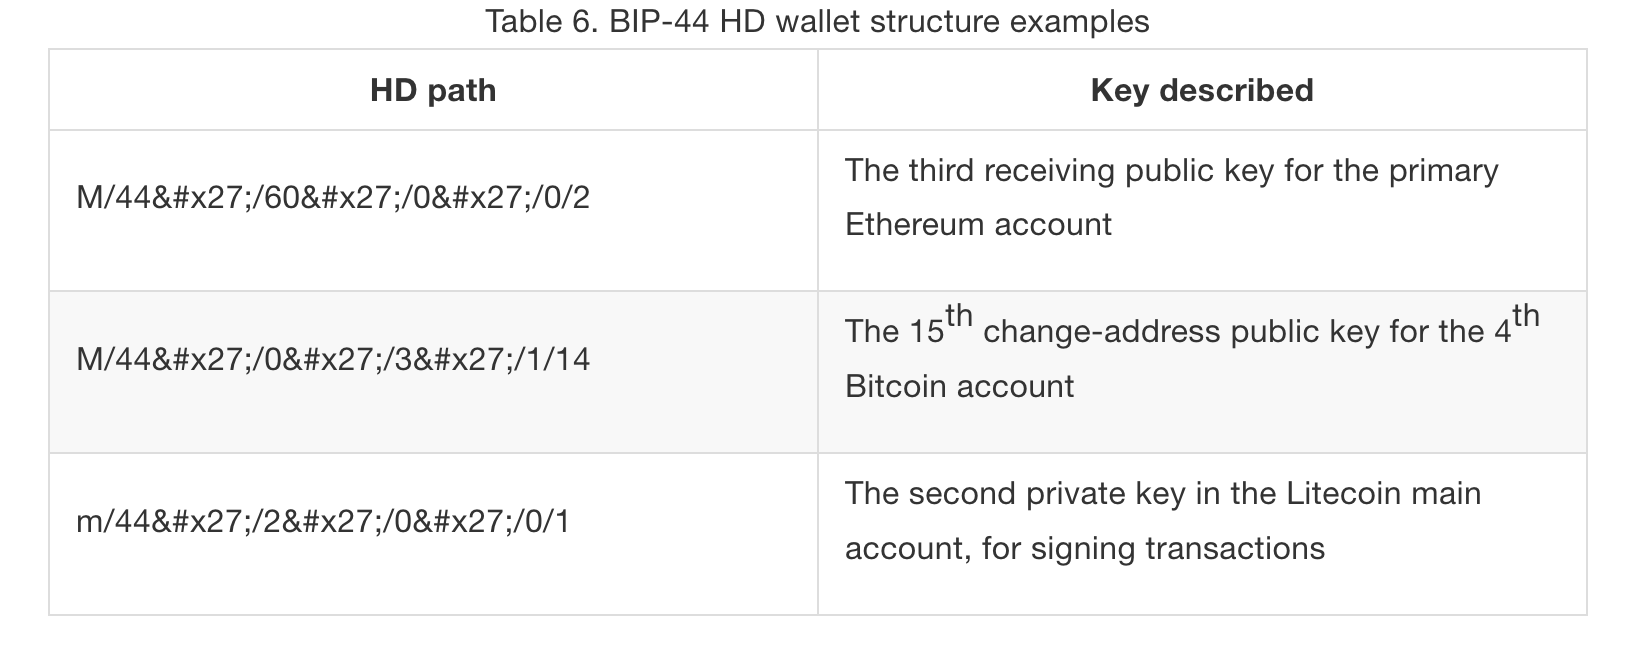